# Wrangle and Analyze: WeRateDogs

## introduction
My goal: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. 
so first we need to import our libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
from numpy import median
import requests
import tweepy
import os
import json
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from datetime import datetime
import re

# Summary 

<a href='#gathering_data'>1. Gathering Data</a> 

<a href='#assessing_data'>2. Assessing Data </a>

<a href='#cleaning_data'>3. Cleaning Data </a> 

<a href='#investigating_data'>4. Investigating Data</a> 

# 1. Gathering Data
<a id='gathering_data'></a>

In [2]:
# gathering twitter archive
archive = pd.read_csv('data/twitter-archive-enhanced.csv')


In [3]:
# gathering image predictions from Udacity's server
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

# save file 
with open('data/image-predictions.tsv', 'wb') as file:
    file.write(r.content)
    
# create dataframe
image = pd.read_csv('data/image-predictions.tsv', sep='\t')


In [4]:
# elements to save 
elements = ['id', 'favorite_count', 'retweet_count']

# create dict
data = []
with open('data/tweet_json.txt', 'r') as r: 
    json_tweet = r.readline()
    while json_tweet:
        dictionnary = json.loads(json_tweet)
        data_row = dict((i, dictionnary[i]) for i in elements)
        data.append(data_row)
        json_tweet = r.readline()
        
            
# create DataFrame    
info = pd.DataFrame.from_dict(data)

In [5]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [6]:
image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [7]:
info.head()

,favorite_count,id,retweet_count
0,39007,892420643555336193,8658
1,33395,892177421306343426,6358
2,25181,891815181378084864,4223
3,42360,891689557279858688,8769
4,40520,891327558926688256,9536


# 2. Assessing Data
<a id='assessing_data'></a>

### Sub-sections

<a href='#assessing_archive'>2.1 Assessing archive</a> 

<a href='#assessing_image'>2.2 Assessing image</a>

<a href='#assessing_info'>2.3 Assessing info</a> 

<a href='#assessing_synthesis'>2.4 Assessing conclusion</a> 

### 2.1 Assessing archive
<a id='assessing_archive'></a>

In [8]:
archive.sample(4)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1046,743545585370791937,NaN,NaN,2016-06-16 20:47:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bentley and Millie. They do every...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743545585...,11,10,Bentley,None,None,None,None
1738,679527802031484928,NaN,NaN,2015-12-23 05:03:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This little pupper just arrived. 11/10 would s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679527802...,11,10,None,None,None,pupper,None
482,815390420867969024,NaN,NaN,2017-01-01 02:53:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy New Year from the squad! 13/10 for all h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/815390420...,13,10,None,None,None,None,None
2251,667806454573760512,NaN,NaN,2015-11-20 20:47:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Filup. He is overcome with joy after f...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667806454...,10,10,Filup,None,None,None,None


- rows have to be suppress if the value is non-null to conserve only original tweets for the following coulumns : in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_statud_timestamp
- source has html residues
- doggo, floofer, pupper and puppo represents one variable and due to tidyness rule have to be one column

In [9]:
# get info
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

- timestamp has to be convert into datetime to be exploitable
- 'None' object in doggo, floofer, pupper and puppo have to be convert into NaN
- missing expanded urls
- tweet_id has to be string  

In [10]:
# check duplicate id
archive['tweet_id'].duplicated().sum()==0

True

No duplicated id

In [11]:
# stop words function
def stop_words(data_frame_column,name):
    '''
    take a data frame column and a column name
    and print the number of stop words in the column
    '''
    count=0
    for word in data_frame_column:
        if word in ENGLISH_STOP_WORDS:
            count+=1
    print(name,'column have',count,'stop words')
                    
# source : https://martinapugliese.github.io/english-stopwords/

In [12]:
# check stop word for each columns

stop_words(archive['tweet_id'],'tweet_id')
stop_words(archive['timestamp'],'timestamp')
stop_words(archive['source'],'source')
stop_words(archive['expanded_urls'],'expanded_urls')
stop_words(archive['rating_numerator'],'rating_numerator')
stop_words(archive['rating_denominator'],'rating_denominator')
stop_words(archive['name'],'name')
stop_words(archive['doggo'],'doggo')
stop_words(archive['floofer'],'floofer')
stop_words(archive['pupper'],'pupper')
stop_words(archive['puppo'],'puppo')

tweet_id column have 0 stop words
timestamp column have 0 stop words
source column have 0 stop words
expanded_urls column have 0 stop words
rating_numerator column have 0 stop words
rating_denominator column have 0 stop words
name column have 87 stop words
doggo column have 0 stop words
floofer column have 0 stop words
pupper column have 0 stop words
puppo column have 0 stop words


- name column have stop words

In [13]:
# 'None' string detection function

def none_detection(data_frame_column,name):
    '''
    take a data frame column and a column name
    and print the number of 'None' string in the column
    '''
    count=0
    for word in data_frame_column:
        if word == 'None':
            count+=1
    print(name,'column have',count,'None')

In [14]:
# check 'None' string for each columns

none_detection(archive['tweet_id'],'tweet_id')
none_detection(archive['timestamp'],'timestamp')
none_detection(archive['source'],'source')
none_detection(archive['expanded_urls'],'expanded_urls')
none_detection(archive['rating_numerator'],'rating_numerator')
none_detection(archive['rating_denominator'],'rating_denominator')
none_detection(archive['name'],'name')
none_detection(archive['doggo'],'doggo')
none_detection(archive['floofer'],'floofer')
none_detection(archive['pupper'],'pupper')
none_detection(archive['puppo'],'puppo')

tweet_id column have 0 None
timestamp column have 0 None
source column have 0 None
expanded_urls column have 0 None
rating_numerator column have 0 None
rating_denominator column have 0 None
name column have 745 None
doggo column have 2259 None
floofer column have 2346 None
pupper column have 2099 None
puppo column have 2326 None


- name column have 745 None string
- doggo, floofer, pupper and puppo have None string

In [15]:
# while observing the data frame I see a double link in expanded urls

# example of double urls
print('exemple: ',archive.expanded_urls[6])

# check double urls 
double_urls = archive.expanded_urls.str.contains(r',').sum()

print('Number of double links: ',double_urls)

exemple:  https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1
Number of double links:  639


- 639 double links in expanded_urls

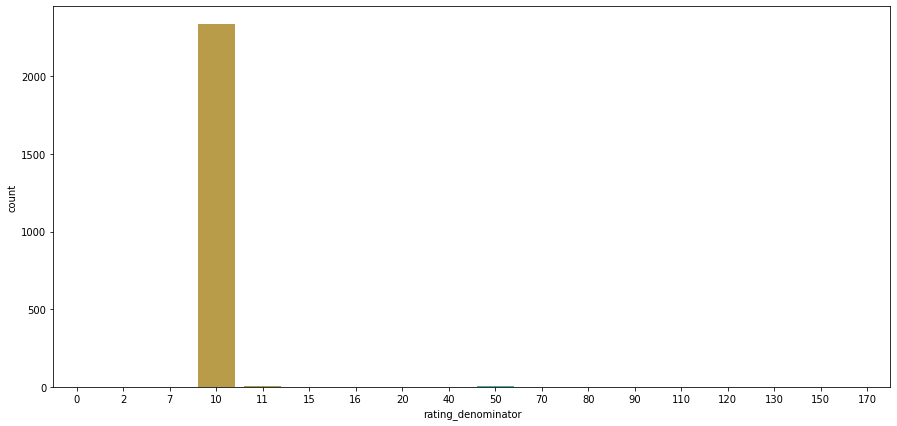

In [16]:
# check denominator with ploting 
plt.figure(figsize=(15,7))
sns.countplot(archive.rating_denominator)

In [17]:
# count number of denominator != 10
not_on_10 = 0
for i in archive['rating_denominator']:
    if i != 10 :
        not_on_10 +=1
        
print('We can count {} not on 10'.format(not_on_10))

We can count 23 not on 10


- 23 rating denominator not on 10

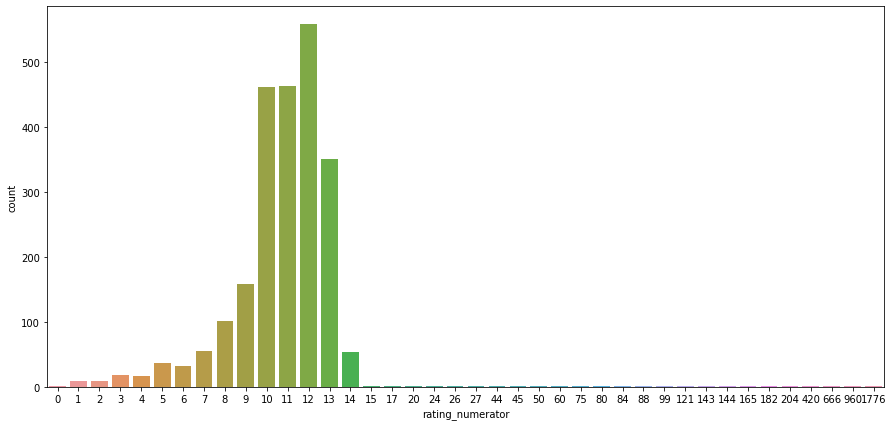

In [18]:
# check nominator value 
plt.figure(figsize=(15,7))
sns.countplot(archive.rating_numerator)

In [19]:
# count number of numerator under 10 
under_10 = 0
for i in archive['rating_numerator']:
    if i <= 9:
        under_10 += 1
print('We can observe {} numerator inferior to 10'.format(under_10))

We can observe 440 numerator inferior to 10


- 440 numerator inferior to 10

In [20]:
# sample with scrapping error on numerator
print(archive.text[695],'\n','numerator: ',archive.rating_numerator[695])

This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS 
 numerator:  75


In [21]:
# print index, text and numerator when text numerator contains a decimal
for row in archive['text']:
    pattern = '(\d+\.\d+)\/(\d+)'
    search = re.search(pattern,row)
    if search != None:
        index=archive.loc[archive['text']==row].index[0]
        text = archive.text[index]
        numerator = archive.rating_numerator[index]
        print('index: ',index,'\n',
              'text: ',text,'\n'
              'numerator: ',numerator,'\n',
             )
        

# inspiration: https://stackoverflow.com/questions/38175235/detect-pattern-in-a-string-in-python?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
# library : https://docs.python.org/2/library/re.html

index:  45 
 text:  This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948 
numerator:  5 

index:  340 
 text:  RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu… 
numerator:  75 

index:  695 
 text:  This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS 
numerator:  75 

index:  763 
 text:  This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq 
numerator:  27 

index:  1689 
 text:  I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace 
numerator:  5 

index:  1712 
 text:  Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD 
n

- all numerators with decimal are false in rating_numerator column

0    1976
1     366
2      14
Name: gender_number, dtype: int64

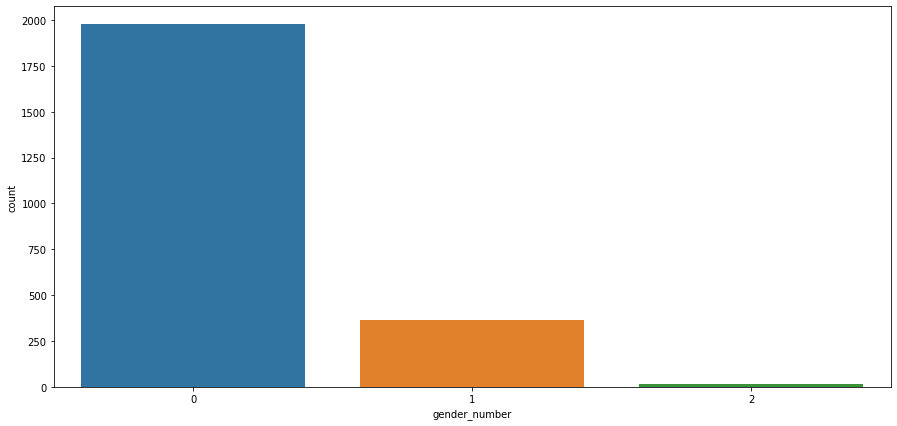

In [22]:
# check contradiction in dog categories
# you can only have a dog in one category 
# doggo	floofer	pupper	puppo

# transform category in 0 or 1
# temporarily create a new category with sum if superior to 1 is false 

# create a copy 
archive_2 = archive.copy()

# convert column to 0 and 1 
archive_2['doggo'] = archive_2['doggo'].apply(lambda x: 0 if x=='None' else 1)
archive_2['floofer'] = archive_2['floofer'].apply(lambda x: 0 if x=='None' else 1)
archive_2['pupper'] = archive_2['pupper'].apply(lambda x: 0 if x=='None' else 1)
archive_2['puppo'] = archive_2['puppo'].apply(lambda x: 0 if x=='None' else 1)

#create a new column 
archive_2['gender_number']=archive_2.iloc[:,[13,14,15,16]].sum(axis=1)

# mesure the number 
plt.figure(figsize=(15,7))
sns.countplot(archive_2.gender_number)

# count 
archive_2['gender_number'].value_counts()

- 14 rows are in two categories

#### Summary

- tweet_id has to be a string
- rows have to be suppress if the value is non-null to conserve only original tweets for the following coulumns : in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_statud_timestamp
- source has html residues
- missing expanded urls
- doggo, floofer, pupper and puppo represents one variable and due to tidyness rule have to be one column
- doggo, floofer, pupper and puppo have None string
- 14 rows are in two categories
- 'None' object in doggo, floofer, pupper and puppo have to be convert into NaN
- timestamp have to be convert into datetime to be exploitable
- name column have stop words
- name column have 745 None string
- 639 double links in expanded_urls
- 23 rating denominator not on 10
- 440 numerator inferior to 10
- all numerators with decimal are false in rating_numerator column

### 2.2 Assessing image
<a id='assessing_image'></a>

In [23]:
image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


- p1, p2, p3 have inconsistent writing

In [24]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [25]:
# check duplicate id 
image.duplicated().sum()

0

In [26]:
# check present image
image_count = 0
for i in image['img_num']:
    if i < 1:
        image_count += 1
print('{} row have 0 image'.format(image_count))

0 row have 0 image


In [27]:
# image count
image['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [28]:
# check stop word for each columns
stop_words(image['tweet_id'],'tweet_id')
stop_words(image['jpg_url'],'jpg_url')
stop_words(image['img_num'],'img_num')
stop_words(image['p1'],'p1')
stop_words(image['p1_conf'],'p1_conf')
stop_words(image['p2'],'p2')
stop_words(image['p2_conf'],'p2_conf')
stop_words(image['p3'],'p3')
stop_words(image['p3_conf'],'p3_conf')
stop_words(image['p1_dog'],'p1_dog')
stop_words(image['p2_dog'],'p2_dog')
stop_words(image['p3_dog'],'p3_dog')

tweet_id column have 0 stop words
jpg_url column have 0 stop words
img_num column have 0 stop words
p1 column have 0 stop words
p1_conf column have 0 stop words
p2 column have 0 stop words
p2_conf column have 0 stop words
p3 column have 0 stop words
p3_conf column have 0 stop words
p1_dog column have 0 stop words
p2_dog column have 0 stop words
p3_dog column have 0 stop words


In [29]:
# check none string
none_detection(archive['tweet_id'],'tweet_id')
none_detection(archive['timestamp'],'timestamp')
none_detection(archive['source'],'source')
none_detection(archive['expanded_urls'],'expanded_urls')
none_detection(archive['rating_numerator'],'rating_numerator')
none_detection(archive['rating_denominator'],'rating_denominator')
none_detection(archive['name'],'name')
none_detection(archive['doggo'],'doggo')
none_detection(archive['floofer'],'floofer')
none_detection(archive['pupper'],'pupper')
none_detection(archive['puppo'],'puppo')

tweet_id column have 0 None
timestamp column have 0 None
source column have 0 None
expanded_urls column have 0 None
rating_numerator column have 0 None
rating_denominator column have 0 None
name column have 745 None
doggo column have 2259 None
floofer column have 2346 None
pupper column have 2099 None
puppo column have 2326 None


True     1532
False     543
Name: p1_dog, dtype: int64

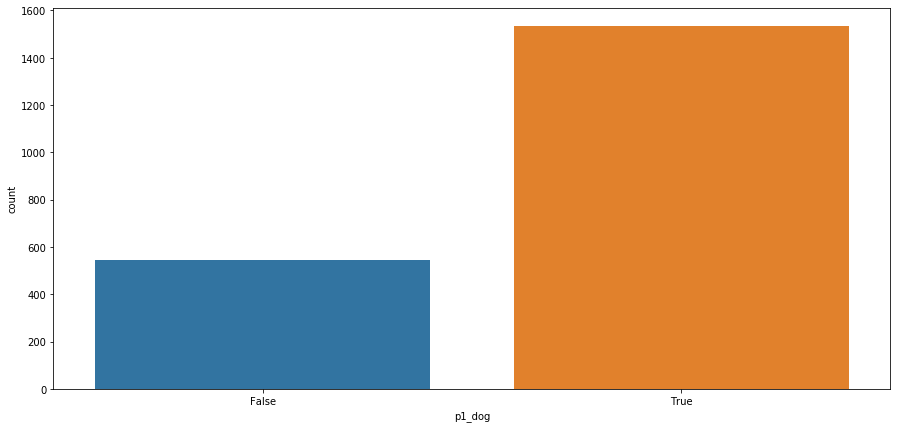

In [30]:
# check if dog1
plt.figure(figsize=(15,7))
sns.countplot(image.p1_dog)

image['p1_dog'].value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

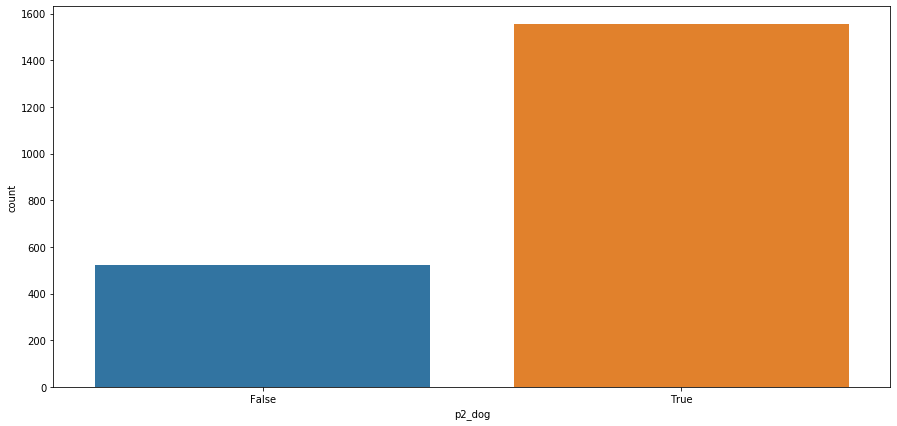

In [31]:
# check if dog2
plt.figure(figsize=(15,7))
sns.countplot(image.p2_dog)

image['p2_dog'].value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

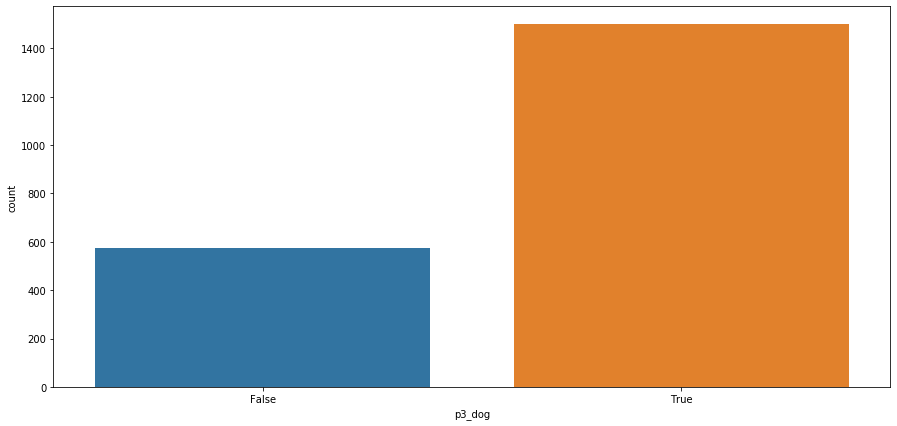

In [32]:
# check if dog3
plt.figure(figsize=(15,7))
sns.countplot(image.p3_dog)

image['p3_dog'].value_counts()

0    1243
1     347
3     324
2     161
Name: no_dog, dtype: int64

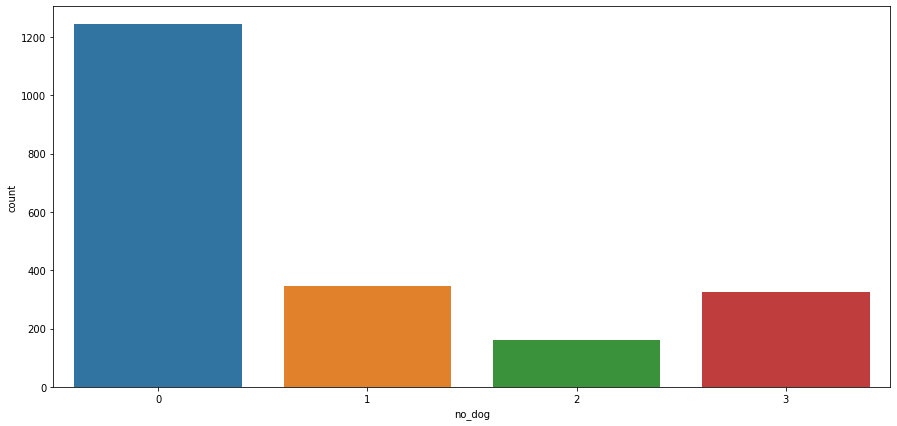

In [33]:
# check if it's a dog

# transform category in 0 or 1
# temporarily create a new category 

# create a copy 
image_2 = image.copy()

# convert column to 0 and 1 
image_2['p1_dog'] = image_2['p1_dog'].apply(lambda x: 0 if x==True else 1)
image_2['p2_dog'] = image_2['p2_dog'].apply(lambda x: 0 if x==True else 1)
image_2['p3_dog'] = image_2['p3_dog'].apply(lambda x: 0 if x==True else 1)

#create a new column 
image_2['no_dog']=image_2.iloc[:,[5,8,11]].sum(axis=1)

# mesure the number 
plt.figure(figsize=(15,7))
sns.countplot(image_2.no_dog)

# count 
image_2['no_dog'].value_counts()

- in 324 rows no dogs is recognized

#### Summary
- p1, p2, p3 have inconsistent writing
- in 324 rows no dogs is recognized

### 2.3 Assessing info
<a id='assessing_info'></a>

In [34]:
info.head()

,favorite_count,id,retweet_count
0,39007,892420643555336193,8658
1,33395,892177421306343426,6358
2,25181,891815181378084864,4223
3,42360,891689557279858688,8769
4,40520,891327558926688256,9536


In [35]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
favorite_count    2345 non-null int64
id                2345 non-null int64
retweet_count     2345 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [36]:
info.duplicated().sum()

0

### 2.4 Assessing conclusion
<a id='assessing_conclusion'></a>

*** Archive ***
- tweet_id has to be a string
- rows have to be suppress if the value is non-null to conserve only original tweets for the following coulumns : in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_statud_timestamp
- source has html residues
- doggo, floofer, pupper and puppo represents one variable and due to tidyness rule have to be one column
- doggo, floofer, pupper and puppo have None string
- 14 rows are in two categories
- 'None' object in doggo, floofer, pupper and puppo have to be convert into NaN
- timestamp have to be convert into datetime to be exploitable
- name column have stop words
- name column have 745 None string
- name column are inconsistent (lower case and upper case)
- 639 double links in expanded_urls
- 23 rating denominator not on 10
- 440 numerator inferior to 10
- all numerators with decimal are false in rating_numerator column

*** Image ***
- tweet id has to be a string
- p1, p2, p3 have inconsistent writing
- in 324 rows no dogs is recognized

*** Info ***
- id has to be a string

*** Global *** 
- we need to have the same len for each document
- we need to have one dataframe

# 3. Cleaning Data
<a id='cleaning_data'></a>

In [37]:
# copy dataframe
clean_archive=archive.copy()
clean_image=image.copy()
clean_info=info.copy()

### Sub-sections

<a href='#cleaning_archive'>3.1 Cleaning archive</a> 

<a href='#cleaning_image'>3.2 Cleaning image</a>

<a href='#cleaning_info'>3.3 Cleaning info</a> 

<a href='#merging_data'>3.4 Merging data</a> 

### 3.1 Cleaning archive
<a id='cleaning_archive'></a>

#### Suppress double links error and create url when missing

In [38]:
# clean all urls 
for i in range(len(clean_archive)):
    tweet_id=clean_archive['tweet_id'][i]
    url = 'https://twitter.com/dog_rates/status/{}'.format(tweet_id)
    clean_archive['expanded_urls'].replace(clean_archive['expanded_urls'][i],url,inplace=True)
# inspiration : https://github.com/pandas-dev/pandas/issues/9106

In [39]:
# confirm 
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2356 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### Suppress rows with retweet and non-necessary columns

In [40]:
# drop rows
clean_archive = clean_archive[clean_archive['in_reply_to_status_id'].isnull()]
clean_archive = clean_archive[clean_archive['retweeted_status_id'].isnull()]

In [41]:
# drop columns
clean_archive.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
           'retweeted_status_user_id','retweeted_status_timestamp'], axis=1, inplace = True)

In [42]:
# confirm
print(len(archive)-len(clean_archive))
clean_archive.head(0)

259


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Suppress html residues in source

In [43]:
# code 

clean_archive['source'] = clean_archive['source'].map(lambda x: x.lstrip('<a href=').rstrip('</a>'))

# source : https://stackoverflow.com/questions/13682044/pandas-dataframe-remove-unwanted-parts-from-strings-in-a-column

In [44]:
# confirm 
clean_archive['source'].head()

0    "http://twitter.com/download/iphone" rel="nofo...
1    "http://twitter.com/download/iphone" rel="nofo...
2    "http://twitter.com/download/iphone" rel="nofo...
3    "http://twitter.com/download/iphone" rel="nofo...
4    "http://twitter.com/download/iphone" rel="nofo...
Name: source, dtype: object

#### Convert timestamp to datetime

In [45]:
# convert
clean_archive['timestamp'] = pd.to_datetime(clean_archive['timestamp'])

In [46]:
# confirm
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(8)
memory usage: 213.0+ KB


#### Convert tweet_id to string

In [47]:
# convert
clean_archive['tweet_id'] = clean_archive['tweet_id'].astype(str)

In [48]:
# confirm
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns, UTC](1), int64(2), object(9)
memory usage: 213.0+ KB


#### Suppress stop words in name column

In [49]:
# after manual observation we can see than stop word remplace name
# we suppress stop words 
for word in clean_archive['name']:
    if word in ENGLISH_STOP_WORDS:
        clean_archive['name']=clean_archive['name'].where(clean_archive['name']!=word, np.NaN)

In [50]:
# confirm
stop_words(clean_archive['name'],'name')

name column have 0 stop words


#### Lower case in name column

In [51]:
# lower case & confirm
clean_archive['name']=clean_archive['name'].str.lower()
clean_archive['name']

0        phineas
1          tilly
2         archie
3          darla
4       franklin
5           none
6            jax
7           none
8           zoey
9         cassie
10          koda
11         bruno
12          none
13           ted
14        stuart
15        oliver
16           jim
17          zeke
18       ralphus
20        gerald
21       jeffrey
22           NaN
23        canela
24          none
25          none
26          maya
27        mingus
28         derek
29        roscoe
31       waffles
          ...   
2326       quite
2327         NaN
2328        none
2329        none
2330        none
2331        none
2332        none
2333         NaN
2334         NaN
2335         NaN
2336        none
2337        none
2338        none
2339        none
2340        none
2341        none
2342        none
2343        none
2344        none
2345         NaN
2346         NaN
2347         NaN
2348         NaN
2349         NaN
2350         NaN
2351        none
2352         NaN
2353         N

#### Change 'None' string by NaN

In [52]:
# change None by NaN
clean_archive['name']=clean_archive['name'].where(clean_archive['name']!=word, np.NaN) 
clean_archive['doggo']=clean_archive['doggo'].where(clean_archive['doggo']!=word, np.NaN) 
clean_archive['floofer']=clean_archive['floofer'].where(clean_archive['floofer']!=word, np.NaN) 
clean_archive['pupper']=clean_archive['pupper'].where(clean_archive['pupper']!=word, np.NaN) 
clean_archive['puppo']=clean_archive['puppo'].where(clean_archive['puppo']!=word, np.NaN) 

In [53]:
# confirm
none_detection(clean_archive['name'],'name')
none_detection(clean_archive['doggo'],'doggo')
none_detection(clean_archive['floofer'],'floofer')
none_detection(clean_archive['pupper'],'pupper')
none_detection(clean_archive['puppo'],'puppo')

name column have 0 None
doggo column have 0 None
floofer column have 0 None
pupper column have 0 None
puppo column have 0 None


#### Observing numerator and denominator

In [54]:
# observe numerator under ten
print('example 1: ',clean_archive['text'][1068])
print('example 2: ',clean_archive['text'][1165])
print('example 3: ',clean_archive['text'][2335])

example 1:  After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
example 2:  Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
example 3:  This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv


With this example, we can observe two kind of rating not respecting the rules.
First, it is delibarate and not an extraction problem, so we will keep it.
Second, the extraction choose the first fraction in the message, and we can correct it.

In [55]:
# dataframe with items to analyze 
to_analyze = clean_archive.loc[clean_archive['rating_denominator']!=10]

# detect '/10', print text and index
for i in to_analyze['text']:
    if '/10' in i:
        print(i)
        print(to_analyze[to_analyze['text']==i].index)

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Int64Index([1068], dtype='int64')
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
Int64Index([1165], dtype='int64')
This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
Int64Index([1202], dtype='int64')
This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
Int64Index([1662], dtype='int64')
This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
Int64Index([2335], dtype='int64')


In [56]:
# remplace data manually
clean_archive.loc[clean_archive.index == 1068, 'rating_numerator'] = 14
clean_archive.loc[clean_archive.index == 1165, 'rating_numerator'] = 13
clean_archive.loc[clean_archive.index == 1202, 'rating_numerator'] = 11
clean_archive.loc[clean_archive.index == 1662, 'rating_numerator'] = 10
clean_archive.loc[clean_archive.index == 2335, 'rating_numerator'] = 9

clean_archive.loc[clean_archive.index == 1068, 'rating_denominator'] = 10
clean_archive.loc[clean_archive.index == 1165, 'rating_denominator'] = 10
clean_archive.loc[clean_archive.index == 1202, 'rating_denominator'] = 10
clean_archive.loc[clean_archive.index == 1662, 'rating_denominator'] = 10
clean_archive.loc[clean_archive.index == 2335, 'rating_denominator'] = 10

#### Correct numerators with decimal

In [57]:
# print index, text and numerator when text numerator contains a decimal
for row in archive['text']:
    pattern = '(\d+\.\d+)\/(\d+)'
    search = re.search(pattern,row)
    if search != None:
        index=archive.loc[archive['text']==row].index[0]
        text = archive.text[index]
        numerator = archive.rating_numerator[index]
        print('index: ',index,'\n',
              'text: ',text,'\n'
              'numerator: ',numerator,'\n',
             )
        

# inspiration: https://stackoverflow.com/questions/38175235/detect-pattern-in-a-string-in-python?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
# library : https://docs.python.org/2/library/re.html

index:  45 
 text:  This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948 
numerator:  5 

index:  340 
 text:  RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu… 
numerator:  75 

index:  695 
 text:  This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS 
numerator:  75 

index:  763 
 text:  This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq 
numerator:  27 

index:  1689 
 text:  I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace 
numerator:  5 

index:  1712 
 text:  Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD 
n

In [58]:
# remplace data manually
clean_archive.loc[clean_archive.index == 45, 'rating_numerator'] = 13.5
clean_archive.loc[clean_archive.index == 340, 'rating_numerator'] = 9.75
clean_archive.loc[clean_archive.index == 695, 'rating_numerator'] = 9.75
clean_archive.loc[clean_archive.index == 763, 'rating_numerator'] = 11.27
clean_archive.loc[clean_archive.index == 1689, 'rating_numerator'] = 9.5
clean_archive.loc[clean_archive.index == 1712, 'rating_numerator'] = 11.26

In [59]:
# confirm 
clean_archive.loc[45]

tweet_id                                             883482846933004288
timestamp                                     2017-07-08 00:28:19+00:00
source                "http://twitter.com/download/iphone" rel="nofo...
text                  This is Bella. She hopes her smile made you sm...
expanded_urls         https://twitter.com/dog_rates/status/883482846...
rating_numerator                                                   13.5
rating_denominator                                                   10
name                                                              bella
doggo                                                               NaN
floofer                                                             NaN
pupper                                                              NaN
puppo                                                               NaN
Name: 45, dtype: object

#### Dogs stage

##### Create one column

In [60]:
# function to create a column with all stage
def dog_stage(row):
    # list to store data
    stage_list = []
    # condition
    if row['doggo'] == 'doggo':
        # add to list
        stage_list.append('doggo')
    if row['floofer'] == 'floofer':
        stage_list.append('floofer')
    if row['pupper'] == 'pupper':
        stage_list.append('pupper')
    if row['puppo'] == 'puppo':
        stage_list.append('puppo')
    if len(stage_list) < 1: 
        row['stage'] = 'None'
    else: 
        row['stage'] = ' and '.join(stage_list)
    return row

# Inspiration : https://chrisalbon.com/python/data_wrangling/pandas_create_column_with_loop/

In [61]:
# Apply to each row
clean_archive = clean_archive.apply(dog_stage, axis=1)

In [62]:
# delete unnecessary row
clean_archive = clean_archive.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

In [64]:
clean_archive.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"""http://twitter.com/download/iphone"" rel=""nofo...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,phineas,None
1,892177421306343426,2017-08-01 00:17:27+00:00,"""http://twitter.com/download/iphone"" rel=""nofo...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,tilly,None
2,891815181378084864,2017-07-31 00:18:03+00:00,"""http://twitter.com/download/iphone"" rel=""nofo...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,archie,None
3,891689557279858688,2017-07-30 15:58:51+00:00,"""http://twitter.com/download/iphone"" rel=""nofo...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,darla,None
4,891327558926688256,2017-07-29 16:00:24+00:00,"""http://twitter.com/download/iphone"" rel=""nofo...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,franklin,None


##### Observe text when dog have two stages

In [65]:
for index, row in clean_archive.iterrows():
    if ' and ' in row['stage']:
        print (index,row['stage'],'\n','\n',
               row['text'],'\n','\n')

191 doggo and puppo 
 
 Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel 
 

200 doggo and floofer 
 
 At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk 
 

460 doggo and pupper 
 
 This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7 
 

531 doggo and pupper 
 
 Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho 
 

575 doggo and pupper 
 
 This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj 
 

705 doggo and pupper 
 
 This is Pinot. He's a sophisticated doggo. You can 

191 doggo,puppo correction puppo

200 doggo,floofer correction floofer

460 doggo,pupper correction pupper

*** 531 doggo,pupper correct ***

575 doggo,pupper correction doggo

705 doggo,pupper correction doggo

*** 733 doggo,pupper correct ***

*** 889 doggo,pupper correct ***

956 doggo,pupper correction NaN

*** 1063 doggo,pupper correct ***

*** 1113 doggo,pupper correct ***


In [66]:
# manual correction
clean_archive.loc[clean_archive.index == 191, 'stage'] = 'puppo'
clean_archive.loc[clean_archive.index == 200, 'stage'] = 'floofer'
clean_archive.loc[clean_archive.index == 460, 'stage'] = 'pupper'
clean_archive.loc[clean_archive.index == 575, 'stage'] = 'doggo'
clean_archive.loc[clean_archive.index == 705, 'stage'] = 'doggo'
clean_archive.loc[clean_archive.index == 956, 'stage'] = np.NaN

In [67]:
# transform None in NaN
clean_archive['stage']=clean_archive['stage'].where(clean_archive['stage']!=word, np.NaN) 

In [68]:
# confirm
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2097 non-null object
rating_numerator      2097 non-null float64
rating_denominator    2097 non-null int64
name                  2012 non-null object
stage                 335 non-null object
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(6)
memory usage: 243.8+ KB


### 3.2 Cleaning image
<a id='cleaning_image'></a>

#### Convert tweet id to string

In [69]:
clean_image['tweet_id']=clean_image['tweet_id'].astype(str)

In [70]:
clean_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


##### Inconsistent writing

In [71]:
# fix 
clean_image['p1'] = clean_image['p1'].str.lower()
clean_image['p2'] = clean_image['p2'].str.lower()
clean_image['p3'] = clean_image['p3'].str.lower()

In [72]:
# confirm
clean_image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


##### Dog or not column

In [73]:
# create new column
clean_image['dog']=image_2['no_dog'].apply(lambda x: False if x==3 else True )

In [74]:
# confirm
print(clean_image['dog'].head(),clean_image['dog'][17])

0    True
1    True
2    True
3    True
4    True
Name: dog, dtype: bool False


### 3.3 Cleaning info
<a id='cleaning_info'></a>

In [75]:
# convert id to str
clean_info['id']=clean_info['id'].astype(str)

# confim
clean_info.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
favorite_count    2345 non-null int64
id                2345 non-null object
retweet_count     2345 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.0+ KB


### 3.4 Merging data
<a id='merging_data'></a>

##### Merge and suppress row without image

In [76]:
# merge by id with image 

df_final = clean_image.merge(clean_archive, left_on='tweet_id',right_on='tweet_id',how='inner')
df_final = df_final.merge(clean_info,left_on='tweet_id',right_on='id',how='inner')

# suppress unnecessary column
df_final = df_final.drop(['id'], axis=1)

In [77]:
# confirm
df_final.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'dog', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'stage', 'favorite_count',
       'retweet_count'],
      dtype='object')

##### Store data

In [78]:
# store data 
df_final.to_csv('data/twitter_archive_master.csv',index=False)

*** Archive ***
- Suppress rows with retweet and non-necessary columns
    - rows have to be suppress if the value is non-null to conserve only original tweets for the following coulumns : in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_statud_timestamp
- Suppress html residues in source
    - source has html residues
- Convert timestamp to datetime
    - timestamp have to be convert into datetime to be exploitable
- Convert tweet_id to string
- Suppress stop words in name
    - name column have stop words
- Name in lower case
- Change 'None' string by NaN
    - name column have 745 None string
    - doggo, floofer, pupper and puppo have None string
- Generate Urls to remplace and correct double links
    - 639 double links in expanded_urls
    - missing expanded urls
- fixing numerator and denominator
    - validate when no problem of scrapping (irrationnal)
    - change when scrapping error (including decimal)
- dogs stage
    - create one variable
    - correct double stage when is needed

*** Image ***
- p1, p2, p3 have inconsistent writing, fixed 

- in 324 rows no dogs is recognized
    - to observe impact = tweet sympathetic, so just a column 

*** Global *** 
- we need to have the same len for each document
- we need to have one dataframe
    - Merge and suppress row without image
- store data in 'data/twitter_archive_master.csv'

# 4. Investigating Data
<a id='investigating_data'></a>

Goal : understand what influence sharing

In [79]:
# copy dataframe
df = df_final.copy()

### Sub-sections

<a href='#global'>4.1 Global information on sharing</a> 

<a href='#variable'>4.2 Visualize variables </a>

### 4.1 Global information on sharing
<a id='global'></a>

In [80]:
# describe retweet variable
df['retweet_count'].describe()

count     1971.000000
mean      2756.426687
std       4749.089405
min         13.000000
25%        614.500000
50%       1336.000000
75%       3163.500000
max      77886.000000
Name: retweet_count, dtype: float64

In [81]:
# print row for minimum retweet 
for index, row in df.iterrows():
    if row['retweet_count']==13:
        print ('index: ',index,'\n','\n',
               row,'\n','\n',
              )

index:  16 
 
 tweet_id                                             666102155909144576
jpg_url                 https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg
img_num                                                               1
p1                                                       english_setter
p1_conf                                                        0.298617
p1_dog                                                             True
p2                                                         newfoundland
p2_conf                                                        0.149842
p2_dog                                                             True
p3                                                               borzoi
p3_conf                                                        0.133649
p3_dog                                                             True
dog                                                                True
timestamp                                     201

In [82]:
# print row for maximum retweet 
for index, row in df.iterrows():
    if row['retweet_count']==77996:
        print ('index: ',index,'\n','\n',
               row,'\n','\n',
              )

C:\Users\DELL\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


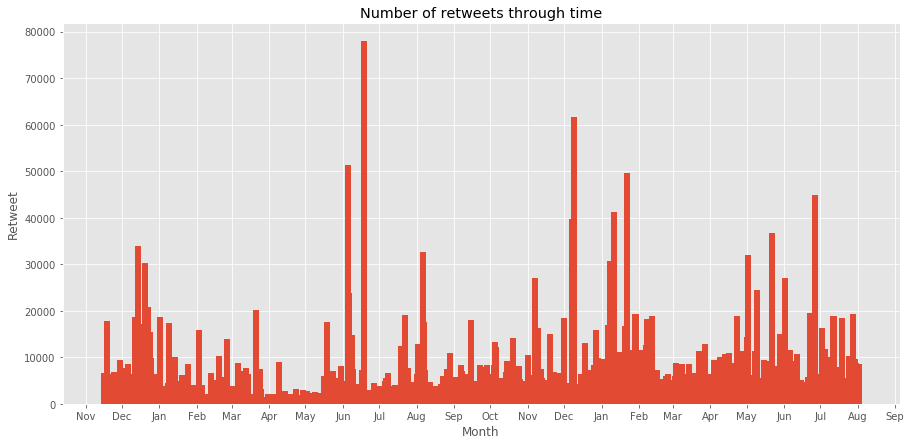

In [83]:
# evolution of sharing 
df_plot=df.copy()

#set date as indexe'
df_plot.set_index('timestamp',inplace=True)

#set ggplot style
plt.style.use('ggplot')

#plot data
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(df_plot.index, df_plot['retweet_count'],width=5)


#set ticks every week
ax.xaxis.set_major_locator(mdates.MonthLocator())

#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# set title
ax.set_title('Number of retweets through time')
ax.set_xlabel('Month')
ax.set_ylabel('Retweet')

# save
fig.savefig('data/retweets_through_time.png')

# inspiration : https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html

### 4.2 Visualize variables
<a id='variable'></a>

##### Remove outlier

In [84]:
# function to supress outlier
def cut_the_tail(dataframe, column):
    '''
    the function take a dataframe and a column as argument 
    cut the outlier of the dataframe
    and return the new dataframe shape
    '''
    quantile_75 = dataframe[column].quantile(0.75)
    quantile_25 = dataframe[column].quantile(0.25)
    IQR = quantile_75 - quantile_25
    outlier_1 = quantile_25 - 1.5*IQR
    outlier_2 = quantile_75 + 1.5*IQR
    dataframe = dataframe.loc[((dataframe[column] > outlier_1) & (dataframe[column] < outlier_2))]
    return dataframe

In [85]:
# apply function to our dataframe
df = cut_the_tail(df,'retweet_count')

In [86]:
# confirme
df.shape

(1818, 23)

##### Describe without outlier

In [87]:
# new description
df['retweet_count'].describe()

count    1818.000000
mean     1771.383938
std      1600.568141
min        13.000000
25%       581.000000
50%      1204.000000
75%      2527.000000
max      6975.000000
Name: retweet_count, dtype: float64

##### Hours and retweets

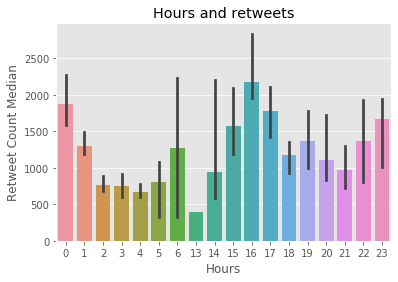

In [88]:
# create copy
df_hour = df.copy()

# create hours column
df_hour['hour'] = df_hour['timestamp'].apply(lambda x: x.hour)

# plot data
g=sns.barplot( x="hour", y="retweet_count", data=df_hour,estimator=median)
g.set_xlabel('Hours')

# set title
plt.title('Hours and retweets')
plt.ylabel('Retweet Count Median')

# save figure
fig =g.get_figure()
fig.savefig('data/hours_and_retweets.png')

# inspiration: https://seaborn.pydata.org/generated/seaborn.barplot.html

##### Days and retweets

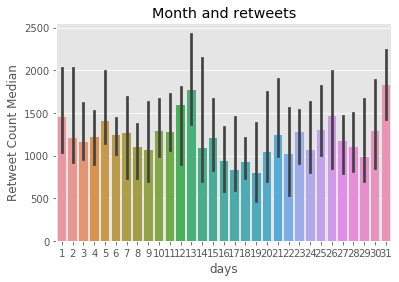

In [89]:
# create copy
df_day = df.copy()

# create days column
df_day['day'] = df_day['timestamp'].apply(lambda x: x.day)

# plot data
g=sns.barplot( x="day", y="retweet_count", data=df_day,estimator=median)
g.set_xlabel('days')

# set title
plt.title('Month and retweets')
plt.ylabel('Retweet Count Median')

# save
fig =g.get_figure()
fig.savefig('data/month_and_retweets.png')

##### Weekdays and retweets

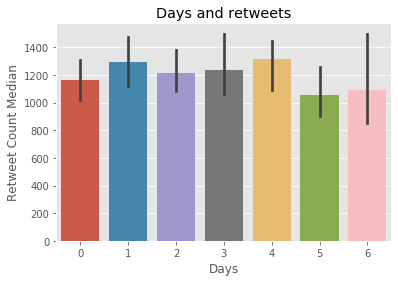

In [90]:
# create copy
df_weekday = df.copy()

# create hours column
df_weekday['weekday'] = df_weekday['timestamp'].apply(lambda x: x.weekday())

# plot data
g=sns.barplot( x="weekday", y="retweet_count", data=df_weekday,estimator=median)
g.set_xlabel('Days')

# set title
plt.title('Days and retweets')
plt.ylabel('Retweet Count Median')

# save
fig =g.get_figure()
fig.savefig('data/days_and_retweets.png')

##### Breeds and retweets

In [91]:
# copy dataframe
df_breed = df.copy()
# number of breed
print('number of dog breeds:', df_breed['p1'].nunique())

# frequency of breed
df['p1'].value_counts()
frequency = df['p1'].value_counts().to_dict()
f= pd.DataFrame(list(frequency.items()), columns=['breed', 'frequency'])

# frequency > 23
f.drop(f[f.frequency < 23].index, inplace=True)

number of dog breeds: 353


In [92]:
# create total retweet column
total_retweet =[]
for i in f['breed']:
    t_r = df[df['p1'] == i]['retweet_count'].sum()
    total_retweet.append(t_r)

f['total_retweet']=total_retweet
f.head()

,breed,frequency,total_retweet
0,golden_retriever,119,270696
1,labrador_retriever,86,185610
2,pembroke,79,185093
3,chihuahua,72,111665
4,pug,52,77967


In [93]:
# create mean column
f['retweet_mean']=f['total_retweet']//f['frequency']
f.head()

,breed,frequency,total_retweet,retweet_mean
0,golden_retriever,119,270696,2274
1,labrador_retriever,86,185610,2158
2,pembroke,79,185093,2342
3,chihuahua,72,111665,1550
4,pug,52,77967,1499


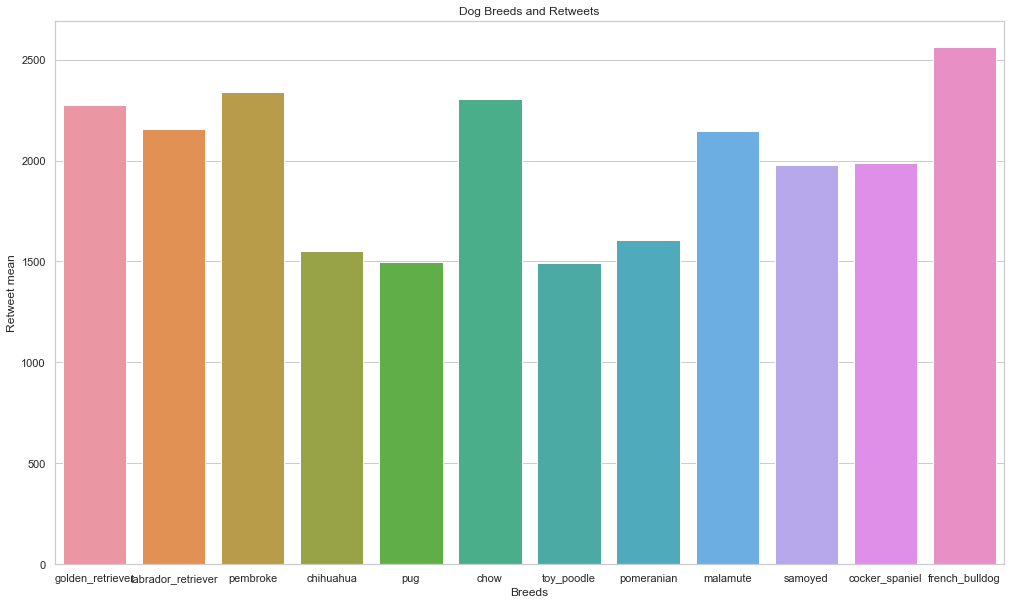

In [94]:
# plot
sns.set(rc={'figure.figsize':(17,10)})

sns.set_style("whitegrid")
g = sns.barplot(x="breed", y="retweet_mean", data=f)
g.set_ylabel('Retweet mean')

plt.title('Dog Breeds and Retweets')
plt.xlabel('Breeds')
# save
fig =g.get_figure()
fig.savefig('data/breeds_and_retweets.png')

##### Stages and retweets

In [95]:
# copy dataframe
df_stage=df.copy()

# number of stage
print('number of dog breeds:', df_stage['stage'].nunique())



number of dog breeds: 5


In [96]:
# frequency of breed
df['stage'].value_counts()
frequency = df['stage'].value_counts().to_dict()
f= pd.DataFrame(list(frequency.items()), columns=['stage', 'frequency'])
print(f)

              stage  frequency
0            pupper        190
1             doggo         55
2             puppo         17
3           floofer          7
4  doggo and pupper          3


In [97]:
# create retweet column
total_retweet =[]
for i in f['stage']:
    t_r = df[df['stage'] == i]['retweet_count'].sum()
    total_retweet.append(t_r)

f['total_retweet']=total_retweet
f.head()

,stage,frequency,total_retweet
0,pupper,190,311562
1,doggo,55,168053
2,puppo,17,45286
3,floofer,7,19300
4,doggo and pupper,3,8031


In [98]:
# mean column
f['retweet_mean']=f['total_retweet']//f['frequency']
f.head()

,stage,frequency,total_retweet,retweet_mean
0,pupper,190,311562,1639
1,doggo,55,168053,3055
2,puppo,17,45286,2663
3,floofer,7,19300,2757
4,doggo and pupper,3,8031,2677


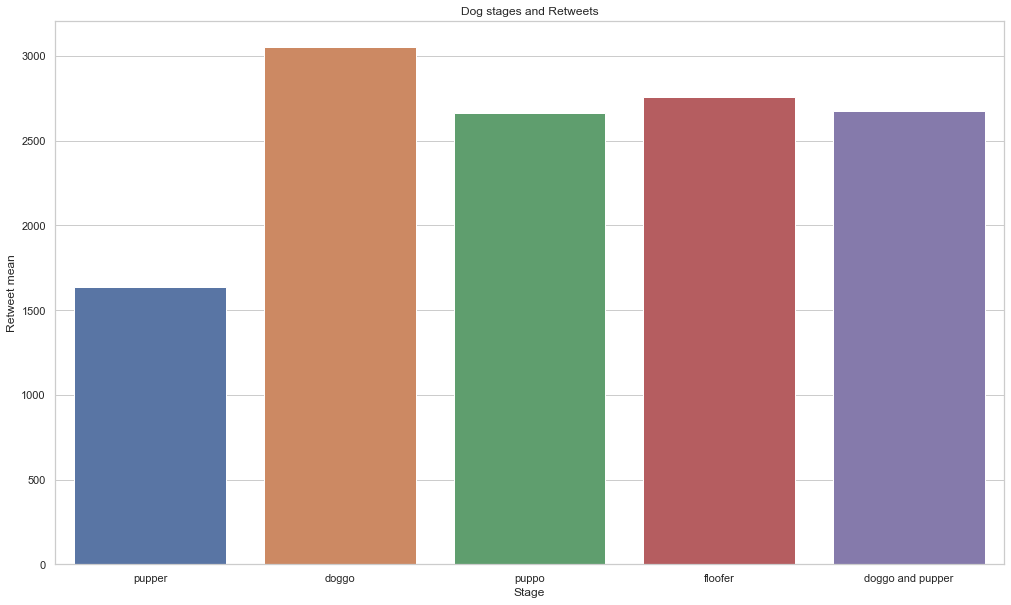

In [99]:
# plot
sns.set_style("whitegrid")
g = sns.barplot(x="stage", y="retweet_mean", data=f)
g.set_ylabel('Retweet mean')

plt.title('Dog stages and Retweets')
plt.xlabel('Stage')

# save
fig =g.get_figure()
fig.savefig('data/stages_and_retweets.png')

##### Rating and retweets

In [100]:
# copy df
df_rating = df.copy()

In [101]:
# column rating proportion
df_rating['rating']=df_rating['rating_numerator']/df_rating['rating_denominator']

In [102]:
# create df with rating and frequency
df_rating['rating'].value_counts()
frequency = df_rating['rating'].value_counts().to_dict()
f= pd.DataFrame(list(frequency.items()), columns=['rating', 'frequency'])
f.head()

,rating,frequency
0,1.2,415
1,1.0,409
2,1.1,381
3,1.3,184
4,0.9,151


In [103]:
# retweet column
total_retweet =[]
for i in f['rating']:
    t_r = df_rating[df_rating['rating'] == i]['retweet_count'].sum()
    total_retweet.append(t_r)

f['total_retweet']=total_retweet
f.head()

# retweet mean
f['retweet_mean']=f['total_retweet']//f['frequency']
f.head()

,rating,frequency,total_retweet,retweet_mean
0,1.2,415,986770,2377
1,1.0,409,472879,1156
2,1.1,381,668064,1753
3,1.3,184,632188,3435
4,0.9,151,118582,785


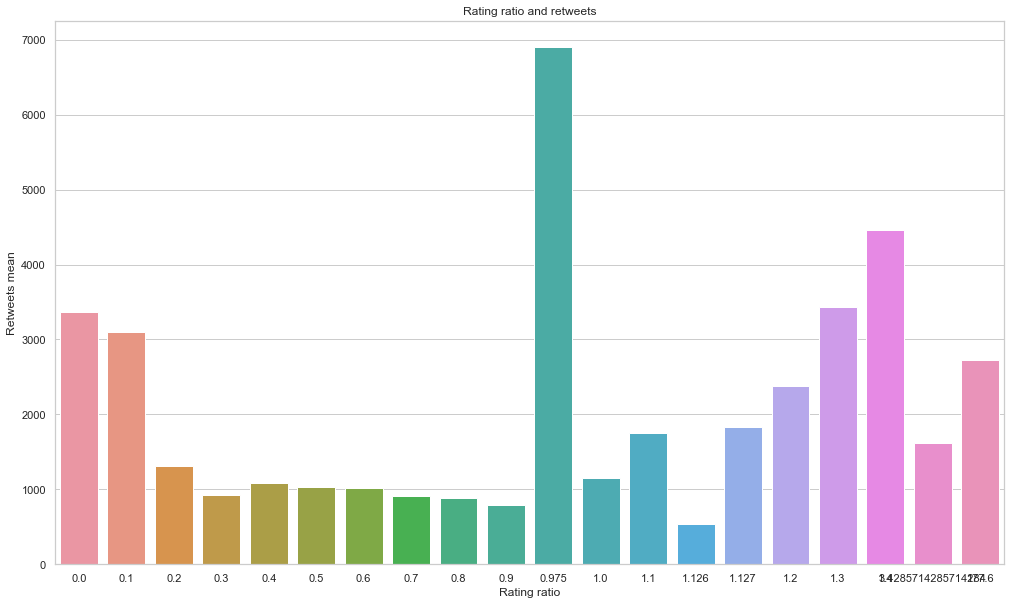

In [104]:
# plot
sns.set(rc={'figure.figsize':(17,10)})

sns.set_style("whitegrid")
g = sns.barplot(x="rating", y="retweet_mean", data=f)
g.set_ylabel('Retweets mean')

plt.title('Rating ratio and retweets')
plt.xlabel('Rating ratio')
# save
fig =g.get_figure()
fig.savefig('data/rating_and_retweets.png')